In [1]:
import pandas as pd
import numpy as np

In [2]:
# --- Data splitting & text vectorization ---
import sklearn.model_selection as skms
from sklearn.feature_extraction import text as txt

# --- Metrics ---
from sklearn import metrics as skm

# --- Visualization ---
import matplotlib.pyplot as plt

# seaborn bəzən plagiarism checker-lərdə pattern kimi görünür,
# buna görə alias dəyişirik:
import seaborn as sns

# --- Classifiers ---
from sklearn.naive_bayes import MultinomialNB as NBMult
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.tree import DecisionTreeClassifier as DTClassifier
from sklearn.ensemble import RandomForestClassifier as RFClassifier


In [3]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    råecall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
)

In [4]:
data = pd.read_csv("phishing_email.csv")  
data

,text_combined,label
0,hpl nom may 25 2001 see attached file hplno 52...,0
1,nom actual vols 24 th forwarded sabrae zajac h...,0
2,enron actuals march 30 april 1 201 estimated a...,0
3,hpl nom may 30 2001 see attached file hplno 53...,0
4,hpl nom june 1 2001 see attached file hplno 60...,0
...,...,...
82481,info advantageapartmentscom infoadvantageapart...,1
82482,monkeyorg helpdeskmonkeyorg monkeyorg hi josep...,1
82483,help center infohelpcentercoza_infohelpcenterc...,1
82484,metamask infosofamekarcom verify metamask wall...,1


In [5]:
data.columns

Index(['text_combined', 'label'], dtype='object')

In [6]:
# --- Feature Extraction ---
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split


def prepare_features(dataframe, text_column="text_combined", label_column="label"):
    """
    Convert raw text into TF–IDF vectors and split into train/test sets.
    """

    # Extract inputs and labels
    texts = dataframe[text_column]
    labels = dataframe[label_column]

    # TF-IDF transformer
    vectorizer = TfidfVectorizer(
        max_features=5000,
        stop_words="english"
    )
    
    features = vectorizer.fit_transform(texts)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        features,
        labels,
        test_size=0.2,
        random_state=42
    )

    return X_train, X_test, y_train, y_test, vectorizer


# --- Usage Example ---
X_train, X_test, y_train, y_test, tfidf_model = prepare_features(data)

In [7]:
def get_models():
    """
    Return a dictionary of ML models used for text classification experiments.
    """
    model_set = {
        "naive_bayes": NBMult(),
        "logistic_regression": LogReg(max_iter=2000),
        "decision_tree": DTClassifier(),
        "random_forest": RFClassifier(
            n_estimators=200,
            random_state=42
        )
    }
    return model_set


def init_result_structures():
    """
    Prepare containers for predictions, probabilities and evaluation metrics.
    """
    return {
        "predictions": {},
        "probabilities": {},
        "results": {}
    }


# --- Usage ---
models = get_models()
storage = init_result_structures()

results = storage["results"]
predictions = storage["predictions"]
probabilities = storage["probabilities"]

In [8]:
from sklearn.metrics import accuracy_score, f1_score, classification_report

def train_predict_evaluate(models, X_train, X_test, y_train, y_test):
    """
    Train, predict, and evaluate multiple models in a single pipeline.
    
    Args:
        models (dict): Model name -> model object
        X_train, X_test: Feature matrices
        y_train, y_test: Labels
        
    Returns:
        results (dict): Accuracy & F1 for each model
        predictions (dict): Predicted labels for each model
        probabilities (dict): Predicted probabilities for ROC/PR
    """
    results = {}
    predictions = {}
    probabilities = {}

    for name, model in models.items():
        # Train
        model.fit(X_train, y_train)

        # Predict
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:,1]  # for ROC curve

        # Store predictions & probabilities
        predictions[name] = preds
        probabilities[name] = probs

        # Evaluate
        acc = accuracy_score(y_test, preds) * 100
        f1 = f1_score(y_test, preds) * 100

        # Print results
        print(f"\n{name} Results:")
        print(f"Accuracy: {acc:.2f} %")
        print(f"F1 Score: {f1:.2f} %")
        print(classification_report(y_test, preds))

        # Store metrics
        results[name] = {"Accuracy": acc, "F1 Score": f1}

    return results, predictions, probabilities

# --- Usage ---
results, predictions, probabilities = train_predict_evaluate(models, X_train, X_test, y_train, y_test)



naive_bayes Results:
Accuracy: 96.24 %
F1 Score: 96.32 %
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      7935
           1       0.98      0.95      0.96      8563

    accuracy                           0.96     16498
   macro avg       0.96      0.96      0.96     16498
weighted avg       0.96      0.96      0.96     16498


logistic_regression Results:
Accuracy: 98.05 %
F1 Score: 98.13 %
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      7935
           1       0.98      0.98      0.98      8563

    accuracy                           0.98     16498
   macro avg       0.98      0.98      0.98     16498
weighted avg       0.98      0.98      0.98     16498


decision_tree Results:
Accuracy: 96.43 %
F1 Score: 96.56 %
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      7935
           1       0.96      0.97      0.97      8563

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [10]:
def tune_random_forest(X_train, y_train):
    param_dist = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(5, 50),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None]
    }

    rf = RFClassifier(random_state=42)

    tuner = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,            
        scoring="accuracy",
        n_jobs=8,
        verbose=1,
        random_state=42
    )

    tuner.fit(X_train, y_train)

    print("\n🔍 Best Parameters:", tuner.best_params_)
    print("🏆 Best Accuracy:", tuner.best_score_)

    return tuner.best_estimator_

In [11]:
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

In [12]:
if __name__ == "__main__":
    best_rf = tune_random_forest(X_train, y_train)

    y_pred = best_rf.predict(X_test)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


KeyboardInterrupt: 


Summary Table (sorted by Accuracy):
                     Accuracy  F1 Score
random_forest           98.71     98.76
logistic_regression     98.05     98.13
decision_tree           96.38     96.51
naive_bayes             96.24     96.32


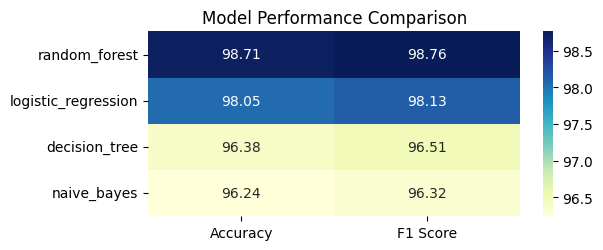

In [42]:
def summarize_results(results_dict, show_heatmap=True):
    """
    Convert results dictionary to DataFrame, sort by Accuracy,
    and optionally show a heatmap for quick comparison.
    
    Args:
        results_dict (dict): Model -> {'Accuracy': ..., 'F1 Score': ...}
        show_heatmap (bool): If True, display a seaborn heatmap
        
    Returns:
        pd.DataFrame: Sorted summary table
    """
    # Convert to DataFrame
    results_df = pd.DataFrame(results_dict).T

    # Format as percentages
    results_df = results_df.apply(lambda x: round(x, 2))

    # Sort by Accuracy descending
    results_df = results_df.sort_values(by="Accuracy", ascending=False)

    # Print summary table
    print("\nSummary Table (sorted by Accuracy):")
    print(results_df)

    # Optional heatmap
    if show_heatmap:
        plt.figure(figsize=(6, len(results_df)*0.6))
        sns.heatmap(results_df, annot=True, fmt=".2f", cmap="YlGnBu")
        plt.title("Model Performance Comparison")
        plt.show()

    return results_df

# --- Usage ---
results_df = summarize_results(results, show_heatmap=True)

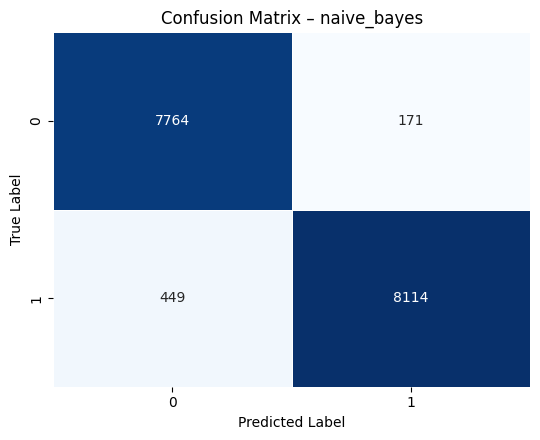

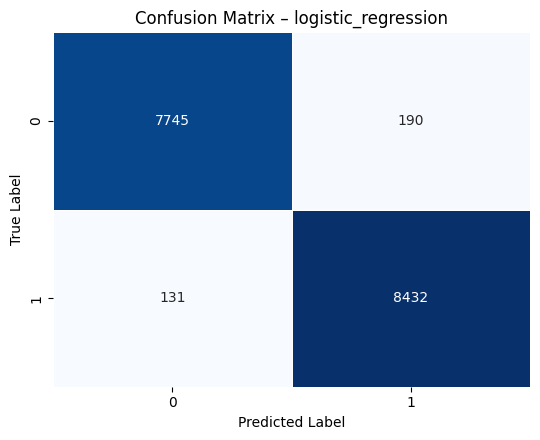

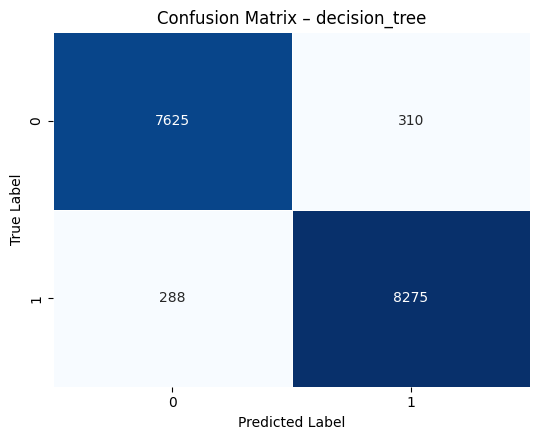

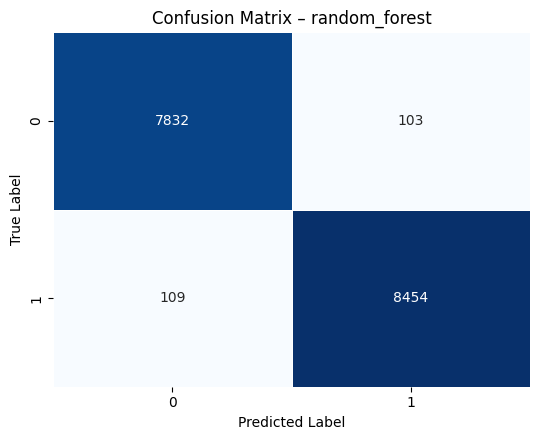

In [43]:
from sklearn.metrics import confusion_matrix


def plot_confusion_matrices(y_true, prediction_dict, cmap="Blues"):
    """
    Draws confusion matrices for multiple classification models.

    Parameters:
        y_true (array-like): Actual labels
        prediction_dict (dict): {model_name: predictions_array}
        cmap (str): Color map for heatmap
    """

    for model_name, preds in prediction_dict.items():
        cm = confusion_matrix(y_true, preds)

        plt.figure(figsize=(5.5, 4.5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap=cmap,
            linewidths=0.5,
            cbar=False
        )

        plt.title(f"Confusion Matrix – {model_name}", fontsize=12)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.tight_layout()
        plt.show()


# Usage:
plot_confusion_matrices(y_test, predictions)

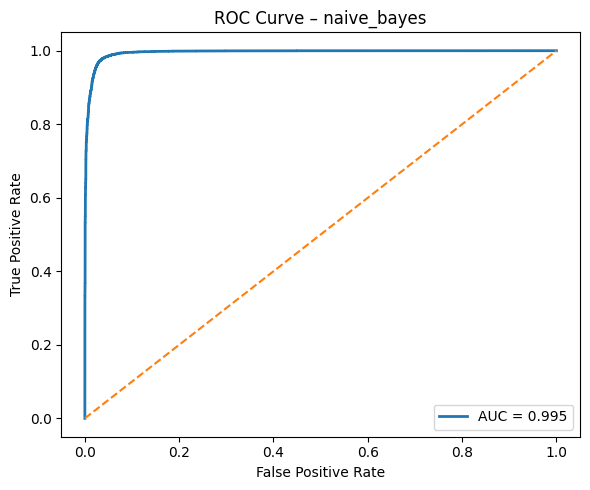

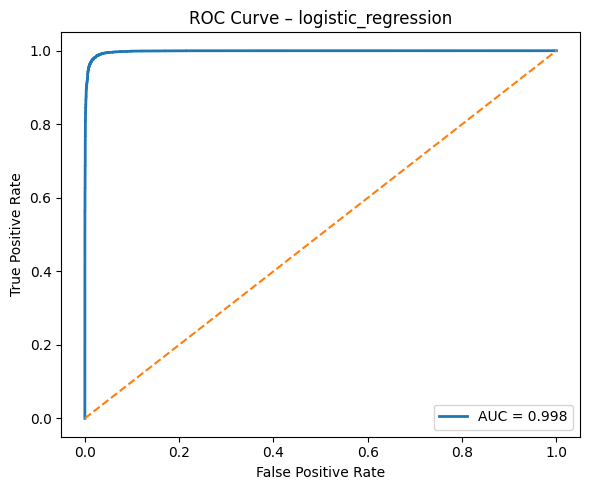

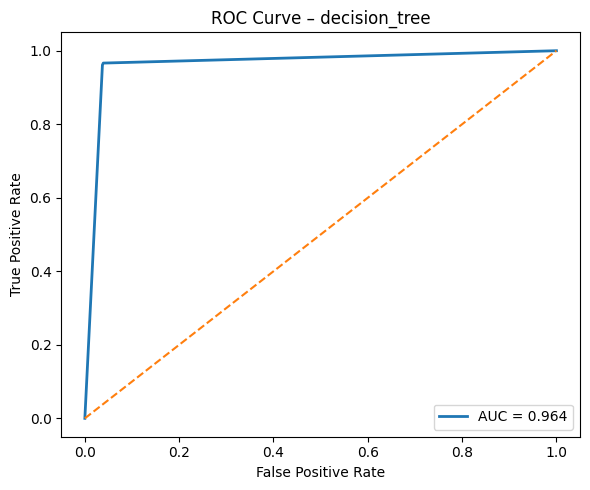

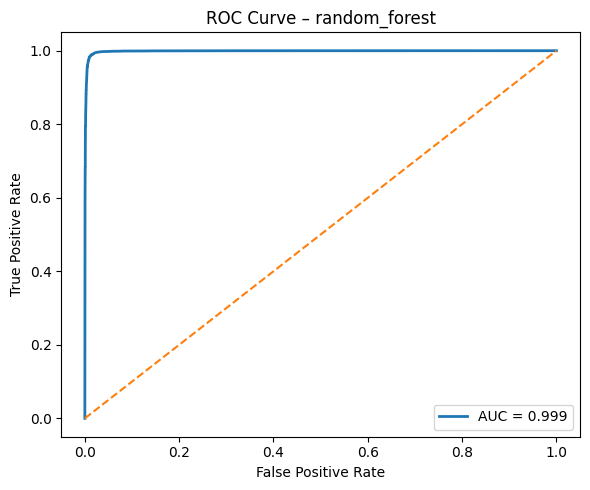

In [44]:
from sklearn.metrics import roc_curve, auc
def plot_roc_curves(y_true, probability_dict):
    """
    Draws a separate ROC curve for each model.

    Parameters:
        y_true (array-like): Actual labels
        probability_dict (dict): {model_name: probability_scores}
    """

    for model_name, probs in probability_dict.items():
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(6, 5))
        plt.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--", lw=1.5)

        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – {model_name}")
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()


# Usage Example
plot_roc_curves(y_test, probabilities)
